# Анализ временных рядов и прогнозирование на примере пассажирского трафика метро

### Цель: Cтроим модель, которая предсказывает, сколько пассажиров будут им пользоваться в ближайшее время

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import pickle
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Импорт библиотек машинного обучения
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# 1. Данные

In [2]:
data_name = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', parse_dates=['date_time'])
data_name.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description           date_time  traffic_volume  
0    scattered clouds 2012-10-02 09:00:00            5545  
1       broken clouds 2012-10-02 10:00:00            4516  
2     overcast clouds 2012-10-02 11:00:00            4767  
3     overcast clouds 2012-10-02 12:00:00            5026  
4       broken clouds 2012-10-02 13:00:00            4918

вам понадобятся только 4 столбца датасета - traffic_volume (наша целевая переменная), date_time, holiday (является ли день некоторым праздником) и temp (температура воздуха).

In [3]:
data0 = data_name.drop(['rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description'], axis=1).drop_duplicates()
data0.head()

holiday    temp           date_time  traffic_volume
0    None  288.28 2012-10-02 09:00:00            5545
1    None  289.36 2012-10-02 10:00:00            4516
2    None  289.58 2012-10-02 11:00:00            4767
3    None  290.13 2012-10-02 12:00:00            5026
4    None  291.14 2012-10-02 13:00:00            4918

# 2. EDA

In [4]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40653 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   holiday         40653 non-null  object        
 1   temp            40653 non-null  float64       
 2   date_time       40653 non-null  datetime64[ns]
 3   traffic_volume  40653 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.6+ MB


### Проверка на отсутствие дубликатов

In [5]:
data0.duplicated().sum()

0

Было интересно проверить два разных способа удаления дубликатов. Способ удаления дубликатов на основе значений столбцов хорошо себя показал для данного случая

In [6]:
# Проверим на пропуски
data0.isnull().sum()

holiday           0
temp              0
date_time         0
traffic_volume    0
dtype: int64

In [7]:
data0.describe()

temp  traffic_volume
count  40653.000000    40653.000000
mean     281.319065     3291.933338
std       13.820109     1984.515804
min        0.000000        0.000000
25%      271.840000     1250.000000
50%      282.870000     3431.000000
75%      292.290000     4952.000000
max      310.070000     7280.000000

In [8]:
fig = px.line(data0, x='date_time', y="traffic_volume")
fig.show()

В исходных данных нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час:
- Сгенерируем равномерную последовательность временных индексов 
- Интерполируем пропущенные значения 

Мы видим большой пробел в данных за 2015 год;
График показывает немало недостающих данных.
Возможны  два варианта работы с данными в 2015 году:
- Удалить все данные до непрерывной последовательности;
- Попытаться присоединить данные до  июля 2014 г. к данным после июня 2015 г.
Последовательных данных за период 2015-2018 гг. достаточно, поэтому выбираем более простой первый способ

In [9]:
# Находим первую запись после пробела с 25 июня по 1 июля 2015 года
start_date = data0.loc[data0['date_time'] > '2015-01-01']['date_time'].iloc[0]
start_date

Timestamp('2015-06-11 20:00:00')

In [10]:
border = pd.Timestamp(year=2016, month=5,day=24, hour=14)

In [11]:
data1 = data0[data0['date_time'] > border]

In [12]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20529 entries, 23596 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   holiday         20529 non-null  object        
 1   temp            20529 non-null  float64       
 2   date_time       20529 non-null  datetime64[ns]
 3   traffic_volume  20529 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 801.9+ KB


In [13]:
fig = px.line(data1, x='date_time', y="traffic_volume")
fig.show()

### Генерация последовательности пропущенных временных меток (индексов) и заполнение пропущенных интервалов

In [14]:
data1['date_time'].min(), data1['date_time'].max()

(Timestamp('2016-05-24 15:00:00'), Timestamp('2018-09-30 23:00:00'))

In [15]:
# индексируем по столбцу 'date_time', что позволяет работать с данными по временному индексу.
data_in = data1.set_index('date_time')
data_in.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20529 entries, 2016-05-24 15:00:00 to 2018-09-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         20529 non-null  object 
 1   temp            20529 non-null  float64
 2   traffic_volume  20529 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 641.5+ KB


### Первый способ обработки данных для восстановления равномерности временных интервалов

In [16]:
# Пересемплируем данные с использованием минимального значения для каждого часа ('H') и применим интерполяцию методом
                                                        #заполнения вперед ('pad') для заполнения пропущенных значений.
data = data_in.resample('H').min().interpolate(method='pad')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20625 entries, 2016-05-24 15:00:00 to 2018-09-30 23:00:00
Freq: H
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         20625 non-null  object 
 1   temp            20625 non-null  float64
 2   traffic_volume  20625 non-null  float64
dtypes: float64(2), object(1)
memory usage: 644.5+ KB


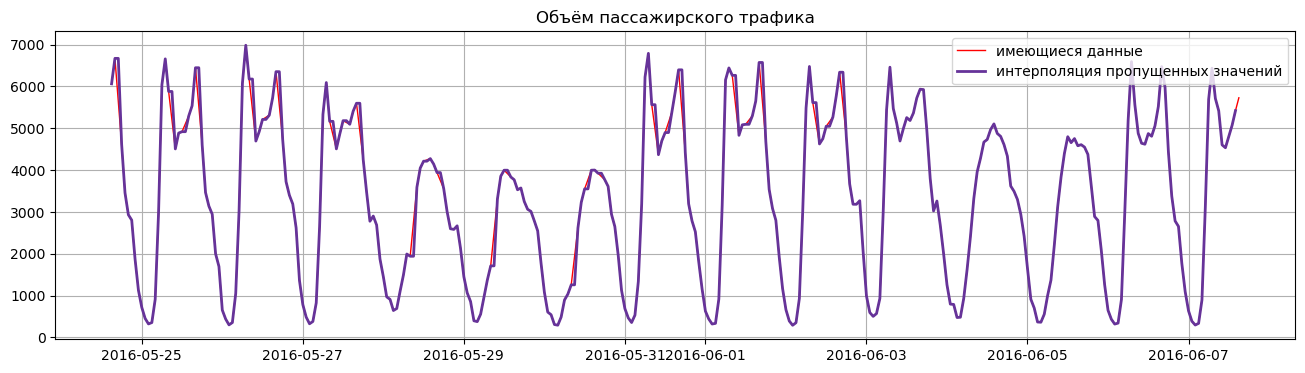

In [18]:
fig, ax = plt.subplots(figsize=(16,4));
ax.plot_date(data_in.index[:24*7*2], data_in['traffic_volume'][:24*7*2], fmt='-', color='red', lw=1, label='имеющиеся данные');
ax.plot_date(data.index[:24*7*2], data['traffic_volume'][:24*7*2], fmt='-', color='rebeccapurple', alpha=1.0, lw=2, label='интерполяция пропущенных значений');
ax.grid()
ax.legend()
ax.set_title('Объём пассажирского трафика', fontsize=12);

### Второй способ обработки данных для восстановления равномерности временных интервалов

In [19]:
data_in.index.min()

Timestamp('2016-05-24 15:00:00')

In [20]:
# создаем ряд дат между начальной и конечной датами, указанными в аргументах.
interpolated_timestamps = pd.date_range(start=data_in.index.min(), end=data_in.index.max(), freq='1H')

In [21]:
# Создаем новый DataFrame с равномерными временными метками (с пустыми данными и индексом=1часу, который содержит равномерно
# распределенные временные метки на протяжении всего диапазона данных:cтроки - time, а столбцы - данные из DataFrame `data1`.))
corr_data1 = pd.DataFrame(index=interpolated_timestamps)
corr_data = corr_data1.join(data_in)

In [22]:
interpolated_data = corr_data.interpolate(method='linear', axis=0)

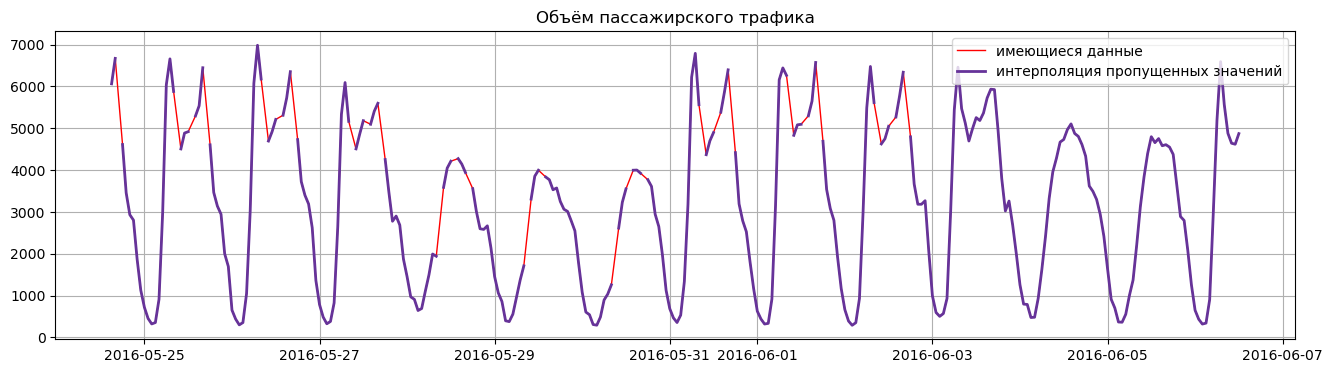

In [23]:
fig, ax = plt.subplots(figsize=(16,4));
ax.plot_date(interpolated_data.index[:24*7*2], interpolated_data['traffic_volume'][:24*7*2], fmt='-', color='red', lw=1, label='имеющиеся данные');
ax.plot_date(corr_data.index[:24*7*2], corr_data['traffic_volume'][:24*7*2], fmt='-', color='rebeccapurple', alpha=1.0, lw=2, label='интерполяция пропущенных значений');
ax.grid()
ax.legend()
ax.set_title('Объём пассажирского трафика', fontsize=12);

### Сравнение способов обработки данных для восстановления равномерности временных интервалов:   графики получились идентичные
Буду использовать датсет data из первого сопособа, потому что в нем использованы минимальные значения и метод интерполяции 'pad'.

# 3. Построение моделей и Прогнозирование

In [24]:
# Функция добавления признаков: дня недели, времени суток и среднего значения трафика 
def create_features(dataframe):
    res = dataframe.copy()
    
    # Кодирование времени суток с помощью sin и cos.
    res['weekday'] = res.index.weekday
    res['hour'] = res.index.hour
    res['hour_sin'] = np.sin(2 * np.pi * res['hour'].values / 23)
    res['hour_cos'] = np.cos(2 * np.pi * res['hour'].values / 23)
    
    # Расчет среднего значения трафика в разрезе времени суток и дней недели
    traffic_mean = res.groupby(['weekday', 'hour'])['traffic_volume'].mean().reset_index()
    res = res.reset_index().merge(traffic_mean, on=['weekday', 'hour'], suffixes=['', '_mean'])
    res = res.set_index('date_time').sort_index()
    res.index.freq = res.index.inferred_freq
    
    # Преобразование категориальных признаков в фиктивные переменные
    res = pd.get_dummies(res, columns=['holiday'])
    res.columns = res.columns.str.replace(' ', '')
    
    return res

In [25]:
# Функция разделения временного ряд на тренировочную и тестовую выборки на основе заданного количества недель - 2-х 
def timeseries_train_test_split(X_array, Y_array, test_n_week=2):
    train_idx = X_array.index < (X_array.index.max() - pd.Timedelta(str(test_n_week) + 'W')) #создаем индекс 'train_idx'
    #который содержит булевые значения, указывающие принадлежит ли каждая временная метка обучающей или тестовой выборке. 
    # находим максимальную временную метку в 'X_array' и вычитаем из нее заданное количество недель для разделения выборок.
    # где W - ед. измерения времени (неделя)
    
    X_train = X_array[train_idx]
    X_test = X_array[~train_idx]
    Y_train = Y_array[train_idx]
    Y_test = Y_array[~train_idx]

    return X_train, X_test, Y_train, Y_test

In [26]:
# Функция построения текущего временного ряда с прогнозом и доверительным интервалом
def plot_model(model, X_train, X_test, Y_train, Y_test, intervals=False, title=''):
    # Определение значений оси абсцисс
    train_idx = range(len(X_train))
    test_idx = range(len(X_train), len(X_train) + len(X_test))
    
    # Вывод текущего временного ряда и его прогноза
    Y_pred = model.predict(X_test)
    
    plt.figure(figsize=(20, 5))
    plt.plot(test_idx, Y_test.values, label='Реальные значения')
    plt.plot(test_idx, Y_pred, 'g', label='Прогнозные значения', linewidth=2.0)
    
    # Вывод доверительного интервала
    if intervals:
        score_mae = cross_val_score(model, X_train, Y_train, cv=TimeSeriesSplit(), scoring='neg_mean_absolute_error')
        lower_bound = Y_pred - (-score_mae.mean() + 1.96 * score_mae.std())
        upper_bound = Y_pred + (-score_mae.mean() + 1.96 * score_mae.std())
    
        plt.plot(test_idx, lower_bound, 'r--', label='Границы доверительного интервала', alpha=0.5)
        plt.plot(test_idx, upper_bound, 'r--', alpha=0.5)
    
    # Вывод оценки качества прогноза модели
    error = r2_score(Y_pred, Y_test)
    plt.title(title + '\n R2 = {0:.3f}'.format(error))
    
    # Вывод легенды
    plt.legend(loc='best')
    plt.show()

In [27]:
# Функция построения прогноза временного ряда с помощью модели SARIMAX
def plot_SARIMAX(model, Y_test, s=168, d=1, n_steps=0, title=''):
    # Определение прогноза модели SARIMAX
    Y_pred = model.fittedvalues
    Y_pred[:s+d] = np.NaN
    
    # Определение необходимости в прогнозе будущего периода времени 
    if n_steps > 0:
        forecast = model.get_forecast(steps=n_steps)
        Y_forecast = Y_pred.append(forecast.predicted_mean)
    else:
        Y_forecast = Y_pred
    
    # Построение текущего временного ряда и прогнозных значений
    plt.figure(figsize=(20, 5))

    plt.plot(Y_test.values, label = 'Реальные значения')
    plt.plot(Y_forecast.values, color='g', label='Прогнозные значения', linewidth=2.0)
    
    # Вывод оценки качества прогноза модели
    error = r2_score(Y_pred[s+d:], Y_test[s+d:])
    plt.title(title + '\n R2 = {0:.3f}'.format(error))
    
    # Вывод прогноза и доверительного интервала для будущего периода времени
    if n_steps > 0:
        intervals = forecast.conf_int(alpha=0.2)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Границы доверительного интервала")
        plt.fill_between(intervals.index, intervals['upper'], intervals['lower'], alpha=0.2, color = "grey")
    
    # Вывод легенды
    plt.legend(loc='upper left')
    plt.show()

In [28]:
data = data[['traffic_volume', 'holiday', 'temp']]

In [29]:
# Добавление новых признаков и удаление данных за предыдущие годы
data_features = create_features(data[data.index.year > 2016])
data_features.iloc[1]

traffic_volume                   1806.000000
temp                              269.950000
weekday                             6.000000
hour                                1.000000
hour_sin                            0.269797
hour_cos                            0.962917
traffic_volume_mean               902.358696
holiday_ChristmasDay                0.000000
holiday_ColumbusDay                 0.000000
holiday_IndependenceDay             0.000000
holiday_LaborDay                    0.000000
holiday_MartinLutherKingJrDay       0.000000
holiday_MemorialDay                 0.000000
holiday_NewYearsDay                 0.000000
holiday_None                        1.000000
holiday_StateFair                   0.000000
holiday_ThanksgivingDay             0.000000
holiday_VeteransDay                 0.000000
holiday_WashingtonsBirthday         0.000000
Name: 2017-01-01 01:00:00, dtype: float64

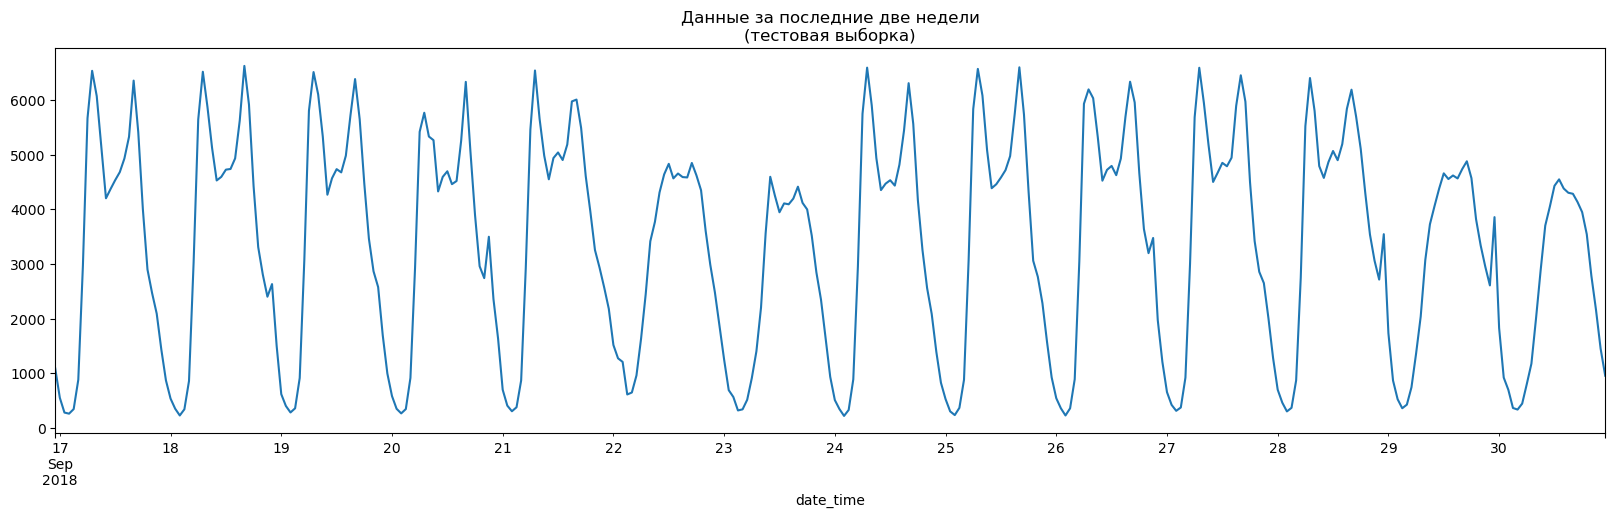

In [30]:
# Разбиение данных на тренировочную и тестовую выборки
X = data_features.iloc[:, 1:]
Y = data_features.iloc[:, 0]

X_train, X_test, Y_train, Y_test = timeseries_train_test_split(X, Y)
   
# Вывод данных за последние две недели
Y_test.plot(figsize=(20, 5))
plt.title('Данные за последние две недели\n(тестовая выборка)')
plt.show()

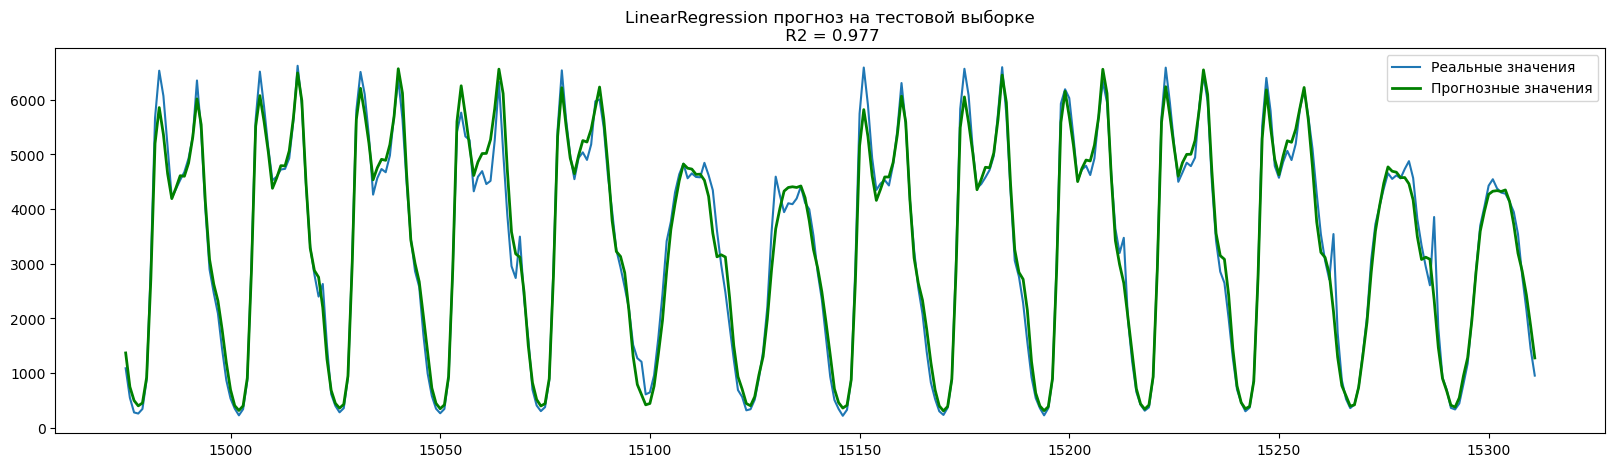

In [31]:
# Построение прогноза временного ряда с помощью линейной регрессии
lr_model = LinearRegression().fit(X_train, Y_train)
plot_model(lr_model, X_train, X_test, Y_train, Y_test, title='LinearRegression прогноз на тестовой выборке')

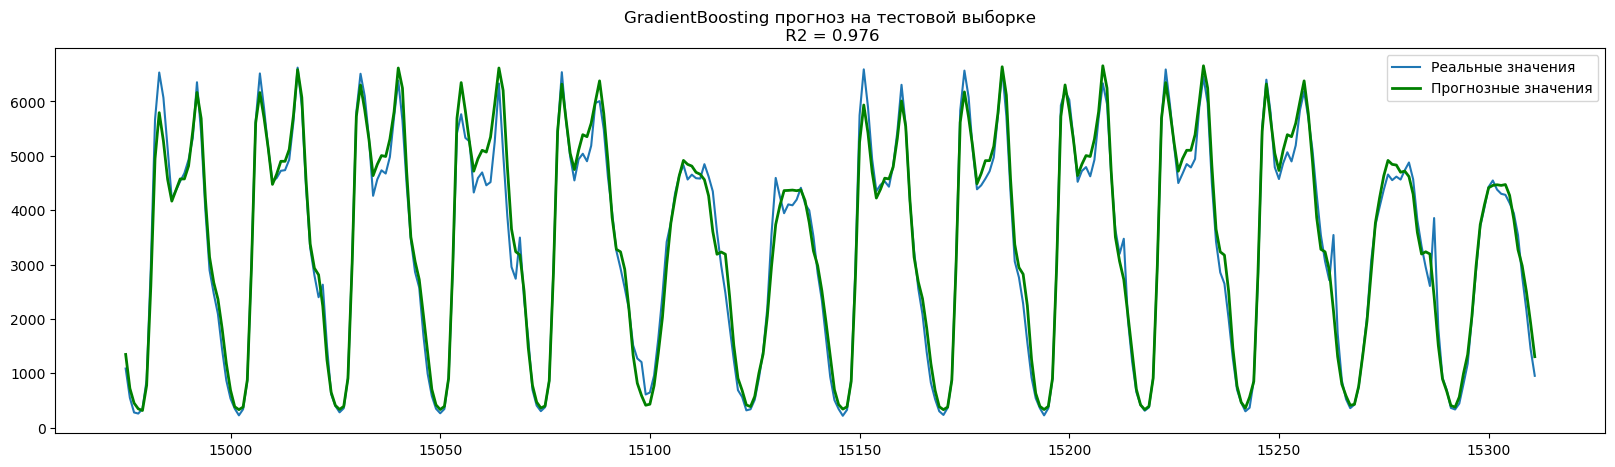

In [32]:
# Построение прогноза временного ряда с помощью градиентного бустинга
gb_model = GradientBoostingRegressor().fit(X_train, Y_train)
plot_model(gb_model, X_train, X_test, Y_train, Y_test, title='GradientBoosting прогноз на тестовой выборке')

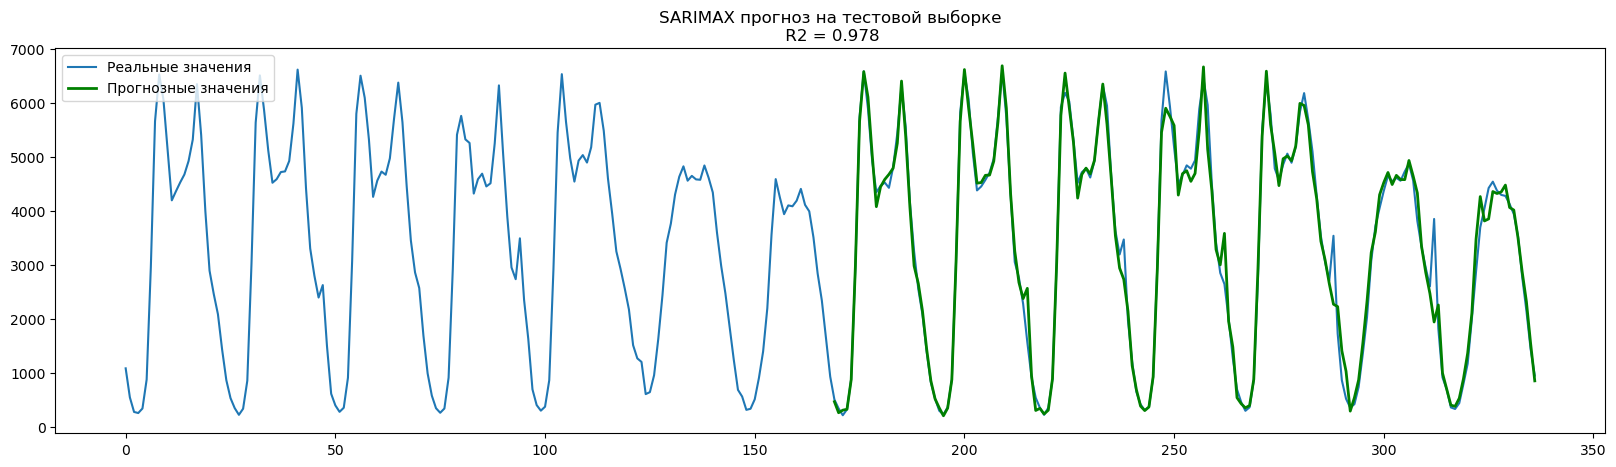

In [33]:
# Построение прогноза временного ряда с помощью SARIMAX модели
sarimax_model = sm.tsa.SARIMAX(Y_test.reset_index(drop=True), order=(1, 1, 1), seasonal_order=(0, 1, 0, 24*7)).fit()
plot_SARIMAX(sarimax_model, Y_test, title='SARIMAX прогноз на тестовой выборке')

C:\Users\Olga\AppData\Local\Temp\ipykernel_18144\1801610498.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



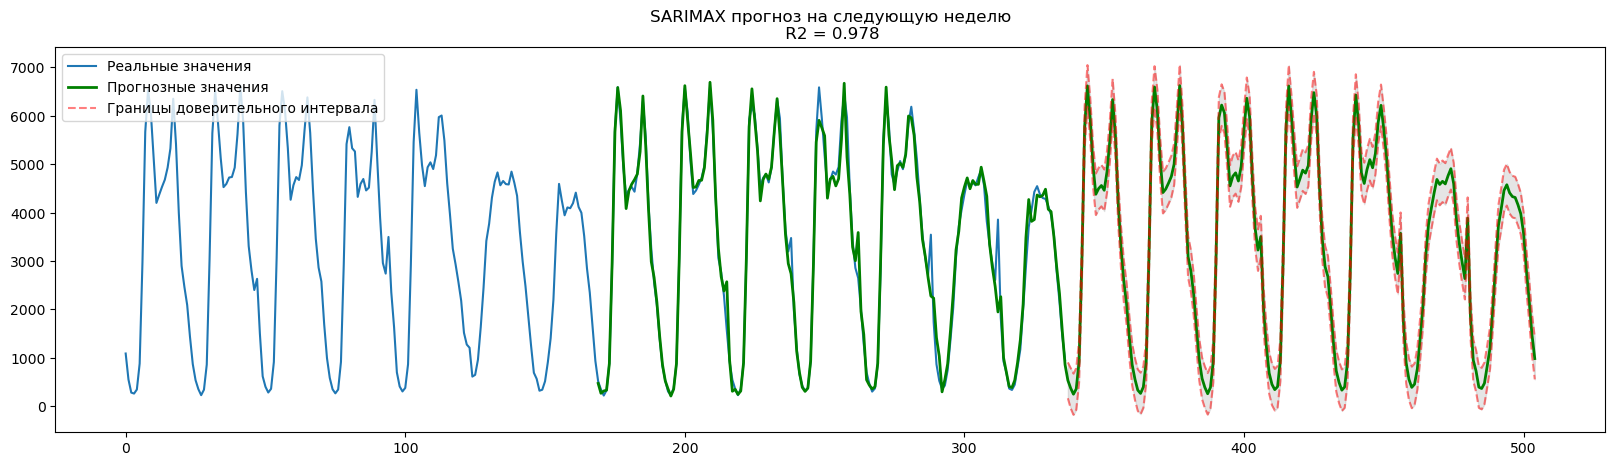

In [34]:
# Построение прогноза на следующую неделю с помощью модели SARIMAX
plot_SARIMAX(sarimax_model, Y_test, n_steps=24*7, title='SARIMAX прогноз на следующую неделю')

# 4. Выводы: 

Линейная регрессия показывает хорошие результаты и без сильных ресурсных затрат (R2=0,977). 

Особой разницы между моделью линейной регрессии (R2=0,977) и SARIMA (R2=0,978) не наблюдается.